In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from pandas import DataFrame
from datetime import datetime
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D ,AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
#from tensorflow.keras.optimizers import Adam




config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

C:\Users\a\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a\AppData\Roaming\Python\Python37\site-packages\tensorf

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


# 출처: https://3months.tistory.com/206 [Deep Play]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1821118829022507444
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8267812044
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14002945447088219839
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
workdir = "E://Ronny_TF//201120_EDC_EYDC_MDC_other_PC//Dataset_EDC_EYDC_MDC_regen"

In [4]:
# < Important note > [ Please download input data from https://mega.nz/#F!CeYGDKyS!uqkmWJ4E2XSGJp_C2VO2gg]
# IC50evaluation//Dataset//Scenario3_EYDC-9K_minmax

dataset = np.load(workdir + "//EYDC9K_dataset.npz") # input file
ss0 = np.load(workdir + '//EYDC9K_dataset_r0_9_1.npz') # split for training and test

In [5]:
x = dataset['x']
y = dataset['y']
# y_linear = dataset['y_lnIC50']
ss0_train = ss0['train']
ss0_test = ss0['test']

In [6]:
training_image_array, training_label_array = x[ss0_train], y[ss0_train]
test_image_array, test_label_array = x[ss0_test], y[ss0_test]

# # In[9]:
# ori = training_image_array
# bat = np.zeros((ori.shape[0],178))
# cat = np.hstack([ori,bat])
# training_image_array = cat

# # In[8]:
# training_image_array.shape

# # In[10]:
# ori2 = test_image_array
# bat2 = np.zeros((ori2.shape[0],178))
# cat2 = np.hstack([ori2,bat2])
# test_image_array = cat2


In [7]:
# In[15]:
ab =[]
for i in range(100,300):
    ab.append(len(training_image_array) % i)
    
print(min(ab), ab.index(min(ab)))

0 37


In [8]:
x.shape

(9590, 41505)

In [9]:
training_image_array.shape

(8631, 41505)

In [10]:
# In[21]:

num_classes = 1
learning_rate = 0.0002
training_epochs = 150
batch_size = 100
# img_rows, img_cols = 154, 154


In [11]:
train_X, train_y, test_X, test_y = training_image_array, training_label_array, test_image_array, test_label_array

# if K.image_data_format() == 'channels_first':
#     train_X = train_X.reshape(train_X.shape[0], 1, img_rows, img_cols)
#     test_X = test_X.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols, 1)
#     test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)


In [12]:
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1],1)
#input_shape = (img_rows, img_cols, 1)

In [13]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8631, 41505, 1) (8631,) (959, 41505, 1) (959,)


In [14]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
# train_X /= 255
# test_X /= 255
print('train_X shape:', train_X.shape)
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

train_X shape: (8631, 41505, 1)
8631 train samples
959 test samples


In [15]:
training_image_array.shape

(8631, 41505)

In [16]:
# In[10]:
with K.tf.device('/GPU:0'):
    inputs = Input(shape=(train_X.shape[1],1),name='inputs')

    x = Conv1D(16, kernel_size=3, strides=2, padding="same")(inputs)
    x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
#     y = x
    x = Activation('tanh')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)

    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)
    
    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)
    
    x = Conv1D(32, kernel_size=3, strides=2, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
#     x = BatchNormalization()(x)
        
    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)
    
        
    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=2, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
#     x = BatchNormalization()(x)
        
    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)
    
        
    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)

#     x = AveragePooling1D(pool_size=8)(x)
    x = Flatten()(x)
    x = Dense(units=2048, name='dense1'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout1') (x)
    x = Activation('relu')(x)

#    x = Reshape((300,1))(x)

#    x = Conv1D(30, kernel_size=150, strides=1, activation = 'relu')(x)
#    x = MaxPooling1D(pool_size=2)(x)
#    x = BatchNormalization()(x)

    x = Dense(units=1024, name='dense5'  ) (x)
    x = BatchNormalization()(x)
    y = x
    x = Dropout(0.1, name='dropout5') (x)
    x = Activation('relu')(x)

    x = Dense(units=512, name='dense6'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout6') (x)
    x = Activation('relu')(x)

    x = Dense(units=1024, name='dense7'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout7') (x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)
    
    x = Dense(units=512, name='dense8'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout8') (x)
    x = Activation('relu')(x)
    
    x = Dense(units=256, name='dense9'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout9') (x)
    x = Activation('relu')(x)

    x = Dense(units=128, name='dense10'  ) (x)
    x = BatchNormalization()(x)
    y = x
    x = Dropout(0.1, name='dropout10') (x)
    x = Activation('relu')(x)


    predictions = Dense(1, activation='linear', name='predictions', kernel_initializer='he_normal')(x)
#     predictions = Dense(1, activation='linear', name='predictions')(x)

    

    model = Model(inputs=inputs, outputs=predictions, name='Test_v2_DNN20190327')
    model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.Adam(learning_rate),
                  metrics=['mse','mae'])


    model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 41505, 1)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 20753, 16)    64          inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 4150, 16)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1

In [19]:
StartTime8 = datetime.now()
print("StartTime :", StartTime8)
with K.tf.device('/GPU:0'):
    model_train = model.fit(train_X, training_label_array, batch_size=batch_size,epochs=training_epochs,verbose=1,
                        validation_data=(test_X, test_label_array))

EndTime8 = datetime.now()
print("EndTime :", EndTime8)

StartTime : 2020-11-23 14:44:45.690032
Train on 8631 samples, validate on 959 samples
Epoch 1/150
8631/8631 [==============================] - 23s 3ms/step - loss: 2.3917 - mean_squared_error: 2.3917 - mean_absolute_error: 1.1417 - val_loss: 3.3305 - val_mean_squared_error: 3.3305 - val_mean_absolute_error: 1.2591
Epoch 2/150
8631/8631 [==============================] - 18s 2ms/step - loss: 1.3682 - mean_squared_error: 1.3682 - mean_absolute_error: 0.8139 - val_loss: 2.8651 - val_mean_squared_error: 2.8651 - val_mean_absolute_error: 1.1458
Epoch 3/150
8631/8631 [==============================] - 19s 2ms/step - loss: 1.1077 - mean_squared_error: 1.1077 - mean_absolute_error: 0.7318 - val_loss: 1.7714 - val_mean_squared_error: 1.7714 - val_mean_absolute_error: 0.9024
Epoch 4/150
8631/8631 [==============================] - 19s 2ms/step - loss: 0.9278 - mean_squared_error: 0.9278 - mean_absolute_error: 0.6689 - val_loss: 1.6661 - val_mean_squared_error: 1.6661 - val_mean_absolute_error: 0

8631/8631 [==============================] - 18s 2ms/step - loss: 0.1578 - mean_squared_error: 0.1578 - mean_absolute_error: 0.2860 - val_loss: 0.8075 - val_mean_squared_error: 0.8075 - val_mean_absolute_error: 0.4900
Epoch 37/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.1606 - mean_squared_error: 0.1606 - mean_absolute_error: 0.2876 - val_loss: 0.8372 - val_mean_squared_error: 0.8372 - val_mean_absolute_error: 0.4843
Epoch 38/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.1516 - mean_squared_error: 0.1516 - mean_absolute_error: 0.2814 - val_loss: 0.8237 - val_mean_squared_error: 0.8237 - val_mean_absolute_error: 0.4784
Epoch 39/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.1521 - mean_squared_error: 0.1521 - mean_absolute_error: 0.2840 - val_loss: 0.8352 - val_mean_squared_error: 0.8352 - val_mean_absolute_error: 0.4845
Epoch 40/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.1543 - m

8631/8631 [==============================] - 18s 2ms/step - loss: 0.1262 - mean_squared_error: 0.1262 - mean_absolute_error: 0.2453 - val_loss: 0.8407 - val_mean_squared_error: 0.8407 - val_mean_absolute_error: 0.4874
Epoch 72/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.1239 - mean_squared_error: 0.1239 - mean_absolute_error: 0.2413 - val_loss: 0.8044 - val_mean_squared_error: 0.8044 - val_mean_absolute_error: 0.4665loss: 0
Epoch 73/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.1242 - mean_squared_error: 0.1242 - mean_absolute_error: 0.2400 - val_loss: 0.8463 - val_mean_squared_error: 0.8463 - val_mean_absolute_error: 0.4827
Epoch 74/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.1405 - mean_squared_error: 0.1405 - mean_absolute_error: 0.2472 - val_loss: 1.0399 - val_mean_squared_error: 1.0399 - val_mean_absolute_error: 0.5100
Epoch 75/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.1

8631/8631 [==============================] - 18s 2ms/step - loss: 0.0574 - mean_squared_error: 0.0574 - mean_absolute_error: 0.1756 - val_loss: 0.7514 - val_mean_squared_error: 0.7514 - val_mean_absolute_error: 0.4431
Epoch 107/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.0532 - mean_squared_error: 0.0532 - mean_absolute_error: 0.1690 - val_loss: 0.7578 - val_mean_squared_error: 0.7578 - val_mean_absolute_error: 0.4430
Epoch 108/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.0517 - mean_squared_error: 0.0517 - mean_absolute_error: 0.1648 - val_loss: 0.7728 - val_mean_squared_error: 0.7728 - val_mean_absolute_error: 0.4404
Epoch 109/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.0533 - mean_squared_error: 0.0533 - mean_absolute_error: 0.1634 - val_loss: 0.7706 - val_mean_squared_error: 0.7706 - val_mean_absolute_error: 0.4321
Epoch 110/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.0631

8631/8631 [==============================] - 18s 2ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1499 - val_loss: 0.7641 - val_mean_squared_error: 0.7641 - val_mean_absolute_error: 0.4256
Epoch 142/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1477 - val_loss: 0.7807 - val_mean_squared_error: 0.7807 - val_mean_absolute_error: 0.4338
Epoch 143/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.0530 - mean_squared_error: 0.0530 - mean_absolute_error: 0.1579 - val_loss: 0.7566 - val_mean_squared_error: 0.7566 - val_mean_absolute_error: 0.4481
Epoch 144/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1476 - val_loss: 0.7931 - val_mean_squared_error: 0.7931 - val_mean_absolute_error: 0.4606
Epoch 145/150
8631/8631 [==============================] - 18s 2ms/step - loss: 0.1310

In [20]:
import json
from keras.models import model_from_json, load_model
workdir = "E://Ronny_TF//201120_EDC_EYDC_MDC_other_PC//Result//EYDC9K//ResNet"
# Option 1: Save Weights + Architecture
model.save_weights(workdir+ '//EYDC9K_ResNet_model_fix_v3.h5')
with open(workdir + '//EYDC9K_ResNet_model_architecture_fix_v3.json', 'w') as f:
    f.write(model.to_json())
# Option 1: Load Weights + Architecture
# with open('model_architecture.json', 'r') as f:
#     new_model_1 = model_from_json(f.read())
# new_model_1.load_weights('model_weights.h5')

In [21]:
# Option 2: Save/Load the Entire Model
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save(workdir + '//EYDC9K_ResNet_model_fix_2080ti_v3.h5')

# Deletes the existing model
# del model  

# Returns a compiled model identical to the previous one
# model = load_model('my_model.h5')

In [22]:
test_eval = model.evaluate(test_X, test_label_array, verbose=1)

959/959 [==============================] - 1s 720us/step


In [23]:
test_eval

[0.7491229666286265, 0.7491229666286265, 0.43965000380316166]

In [24]:
accuracy = model_train.history['mean_squared_error']
val_accuracy = model_train.history['val_mean_squared_error']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

np_acc = np.array(accuracy)
np_val_acc = np.array(val_accuracy)
np_loss = np.array(loss)
np_val_loss = np.array(val_loss)

In [25]:
import matplotlib
from matplotlib import pyplot as plt

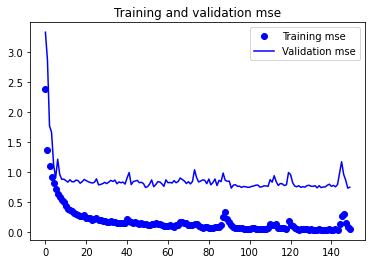

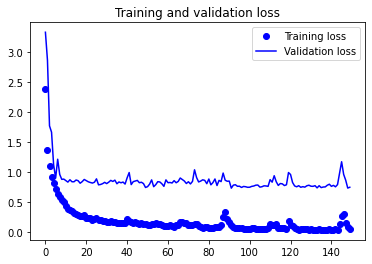

In [26]:
# accuracy = model_train.history['acc']
# val_accuracy = model_train.history['val_acc']
# loss = model_train.history['loss']
# val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training mse')
plt.plot(epochs, val_accuracy, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [27]:
predicted_classes = model.predict(test_X)

In [28]:
predicted_value = predicted_classes

In [29]:
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(test_label_array)
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]

In [30]:
c.to_csv(workdir + '//EYDC9K_ResNet_pred_obs_table.csv')

In [31]:
c

,Predicted,Test
0,2.093127,2.079442
1,1.853775,2.079442
2,-1.384900,-1.507775
3,2.087224,2.079442
4,1.161180,1.111349
...,...,...
954,2.080724,2.079442
955,-1.941010,-2.526984
956,1.896779,2.079442
957,2.073156,2.079442


In [32]:
predicted_value.shape

(959, 1)

In [33]:
from scipy.stats import linregress
linregress(b[0], a[0])

LinregressResult(slope=0.8518089113997673, intercept=0.15805108291683279, rvalue=0.9005077295143825, pvalue=0.0, stderr=0.013296221963029927)

In [34]:
from sklearn.metrics import r2_score
r2_value = r2_score(b,a)
print(r2_value)

0.8086578364822616


In [35]:
rse = ((b[0]-a[0])**2).sum()
mse = rse / len(b)
print("Final rmse value is =",np.sqrt(mse))

Final rmse value is = 0.8655189065697482


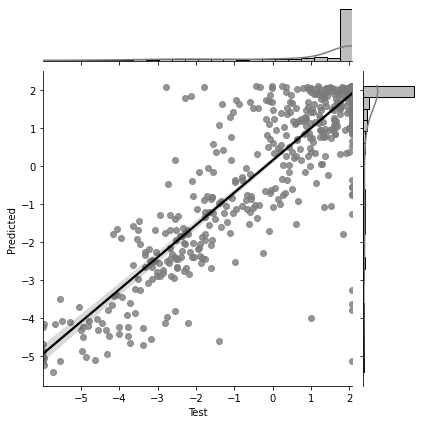

In [36]:
workdir = "E://Ronny_TF//201120_EDC_EYDC_MDC_other_PC//Result//Fig_backbone//EYDC9K"
import seaborn as sns

g = sns.jointplot(x="Test", y="Predicted", data=c, kind='reg', color='#7C7C7C',
                  joint_kws={'line_kws':{'color':'black'}})
g.savefig(workdir+ '//EYDC9K_ResNet.png', dpi=300)